In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

In [45]:
# We will use most populer UCI dataset for classifying spam or ham 
messages=[line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

In [46]:
print(len(messages))

5574


In [47]:
#Let's check one row of dataset how does it looks like
messages[60]

"ham\tYour gonna have to pick up a $1 burger for yourself on your way home. I can't even move. Pain is killing me."

In [48]:
#Displaying first 5 messages
for mess_no,message in enumerate(messages[:5]):
    print(mess_no,message)
    print('\n')
    # enumerate: It allows us to loop over something and have an automatic counter.

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though




In [49]:
mails=pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])

In [50]:
mails.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [51]:
mails.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [52]:
mails.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [53]:
#After analyzing we find that message length can be a important feature.
mails['length']=mails['message'].apply(len)

In [54]:
mails.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Cleaning: Correcting, Completing, Creating, and Converting & Feature Engineering

### Data Visualisation

label
ham     AxesSubplot(0.125,0.125;0.775x0.755)
spam    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

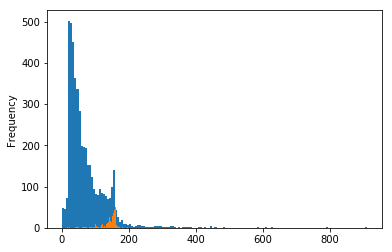

In [55]:
mails.groupby('label')['length'].plot.hist(bins=150)

Looks like spam messages density is between 150 to 200 words length

In [56]:
mails['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

max message length is 910. Let's see what this message says

In [57]:
mails[mails['length']==910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC9D461DA0>,
      dtype=object)

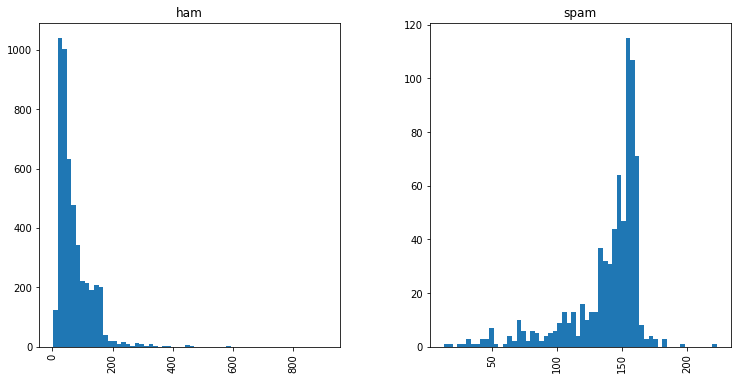

In [58]:
mails.hist(column='length',by='label',bins=60,figsize=(12,6))

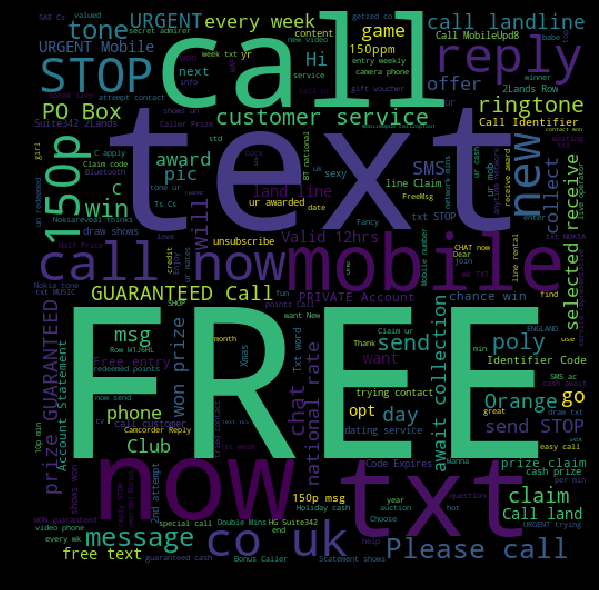

In [67]:
spam_words = ' '.join(list(mails[mails['label']=='spam']['message']))
spam_wc = WordCloud(width=500,height=500).generate(spam_words)
plt.figure(figsize=(12,8),facecolor='K')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(0)

As expected spam messages mostly contains "FREE" , "CALL NOW" etc.

### Noise Removal
Any piece of text which is not relevant to the context of the data and the end-output can be specified as the noise.
For example – language stopwords (commonly used words of a language – is, am, the, of, in etc), URLs or links, social media entities (mentions, hashtags), punctuations and industry specific words. 

In [69]:
def text_process(mess):
    """
    1. remove punc
    2. remove stop words
    3. return list of clean text words
    
    """
    nopunc=[char for char in mess if char not in string.punctuation]
    
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower not in stopwords.words('english')]

In [71]:
#Here is the original data once again
mails.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

### Vectorization
We will go ahead and use scikit CountVectorizer to convert our bag of words into Vector form, where each of rows will represents unique words and each of columns represent our actual text messages. Here, i am using own analyzer but you can use defauit analyzer as well.

In [78]:
bow_transformer=CountVectorizer(analyzer=text_process).fit(mails['message'])

Let's check how many unique vocabulary we have into our data set

In [79]:
print(len(bow_transformer.vocabulary_))

11747


In [82]:
messages_bow=bow_transformer.transform(mails['message'])

In [83]:
print('Shape of Sparse Matrix: ', messages_bow.shape)

Shape of Sparse Matrix:  (5572, 11747)


In [84]:
messages_bow.nnz

79463

### TF - IDF

 - Count how many times does a word occur in each message (Known as term frequency)

 - Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

 - Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [85]:
tfidf_transformer=TfidfTransformer().fit(messages_bow)

In [88]:
# Just checking inverse document frequency of single word
tfidf_transformer.idf_[bow_transformer.vocabulary_['Love']]

6.293484277394333

** Now i will convert entire Bag of words corpus to tfidf corpus **

In [90]:
messages_tfidf=tfidf_transformer.transform(messages_bow)

### Training our dataset using Naive bayes classifier 

In [95]:
from sklearn.model_selection import train_test_split

### Splitting my dataset into train and test

In [96]:
msg_train,msg_test,label_train,label_test=train_test_split(mails['message'],mails['label'],test_size=0.3)

In [97]:
from sklearn.pipeline import Pipeline

Now i will use sklearn pipeline that is very efficient and fast way to do all of the things what i have done before in this notebook manually just to show all the hidden maths and techniques of text processing.

In [98]:
# Here in few lines of code we can preprocess text's. It is scikit capablities that gives fast way to do these short of the things.
pipeline=Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

Now i will fit my training set and predict outputs on test set.

In [99]:
pipeline.fit(msg_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x000001AC9C6AD2F0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocesso...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [100]:
predictions=pipeline.predict(msg_test)

In [101]:
print(confusion_matrix(label_test,predictions))
print('\n')
print(classification_report(label_test,predictions))

[[1464    0]
 [  75  133]]


             precision    recall  f1-score   support

        ham       0.95      1.00      0.98      1464
       spam       1.00      0.64      0.78       208

avg / total       0.96      0.96      0.95      1672



### Thanks for watching my work, please give star if you liked it or suggest me for further improvement.